In [1]:
import pandas as pd
import numpy as np
import gensim
import nltk
import re

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

# helper function to clean texts
def replace_contraction(text):
    contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'can not'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def cleanText(text):
    text = replace_contraction(text)
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = re.sub(r'[0-9,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
    text = text.lower()
    return text


In [2]:
# prepare dataset
df = pd.read_csv("data/study_data.csv")

treatment_label = 'arch_strong'
control_label = 'control'
treatment_control = df[df['arm'].isin([treatment_label,control_label])]
X = np.array(treatment_control['post_q'].apply(cleanText))
# X = np.array(df['post_q'].apply(cleanText))
y = treatment_control['arm']


### Word2Vec Embedding

In [3]:
# tokenize the texts and remove stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def clean_tokenize(X):
    sentences = []
    for res in X:
        tokens = gensim.utils.simple_preprocess(res)
        cleaned_tokens = []
        for token in tokens:
            if token not in stop_words:
                cleaned_tokens.append(token)
        sentences.append(cleaned_tokens)
    return sentences

sentences = clean_tokenize(X)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexa712/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
from gensim.models import Word2Vec

# train word2vec embedding
model = Word2Vec(sentences,size = 50,window = 10,iter = 10)
# sanity check
w1 = 'dormer'
model.wv.most_similar(positive = w1)

[('brick', 0.9997163414955139),
 ('design', 0.9996920228004456),
 ('front', 0.9996743202209473),
 ('house', 0.999661386013031),
 ('home', 0.9996578097343445),
 ('surround', 0.9996386170387268),
 ('symmetrical', 0.9996331334114075),
 ('window', 0.9996323585510254),
 ('one', 0.999631941318512),
 ('chimney', 0.9996238350868225)]

In [19]:
# export the w2vec model
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

/Users/alexa712/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [35]:
# try pre-trained glove embeddings
import gensim.downloader as api
model_gigaword = api.load("glove-wiki-gigaword-100")
glove_big = dict(zip(model_gigaword.wv.index2word, model_gigaword.wv.syn0))

/Users/alexa712/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/Users/alexa712/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


In [36]:
model_gigaword_small = api.load("glove-wiki-gigaword-50")
glove_small = dict(zip(model_gigaword_small.wv.index2word, model_gigaword_small.wv.syn0))

/Users/alexa712/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/Users/alexa712/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


### Model Comparisons

In [22]:
# feature extractions from word2vec

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(word2vec))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(word2vec))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])



In [48]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from tabulate import tabulate
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB



# logreg_w2v = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
#                         ("log reg", LogisticRegression())])
# logreg_w2v_50 = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v_50)), 
#                         ("log reg", LogisticRegression())])
# logreg_w2v_big = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v_big)), 
#                         ("log reg", LogisticRegression())])
# svm_w2v = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
#                         ("svm", SVC(kernel='linear'))])
# # svm_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
# #                         ("svm", SVC(kernel='linear'))])
# svm_w2v_big = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v_big)), 
#                         ("svm", SVC(kernel='linear'))])
# svm_w2v_50 = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v_50)), 
#                         ("svm", SVC(kernel='linear'))])


logreg_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("log reg", LogisticRegression())])
logreg_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("log reg", LogisticRegression())])
logreg_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("log reg", LogisticRegression())])
rf_glove_big = Pipeline([("glove", MeanEmbeddingVectorizer(glove_big)), 
                        ("rf", RandomForestClassifier(n_estimators = 200, oob_score = True, random_state = 47))])

svm_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("svm", SVC(kernel='linear'))])
svm_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("svm", SVC(kernel='linear'))])
svm_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("svm", SVC(kernel='linear'))])

# svm_w2v_big_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v_big)), 
#                         ("svm", SVC(kernel='linear'))])
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
#mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
#bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])

In [49]:
all_models = [
    ("mult_nb", mult_nb),
#     ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("rf_glove_100",rf_glove_big),
#     ("bern_nb_tfidf", bern_nb_tfidf),
    ("logreg_w2v", logreg_w2v),
    ("logreg_glove_50", logreg_glove_small),
    ("logreg_glove_100", logreg_glove_big),
    ("svm_glove_50", svm_glove_small),
    ("svm_w2v", svm_w2v),
    ("svm_glove_big", svm_glove_big),
#     ("svm_w2v_tfidf", svm_w2v_tfidf),
#     ("svm_w2v_big_tfidfd", svm_w2v_big_tfidf)
#     ("w2v_tfidf", etree_w2v_tfidf),
#     ("glove_small", etree_glove_small),
#     ("glove_small_tfidf", etree_glove_small_tfidf),
#     ("glove_big", etree_glove_big),
#     ("glove_big_tfidf", etree_glove_big_tfidf),
]

### Generating the Null Distribution

In [33]:

treatment_label = 'arch_strong'
control_label = 'control'

treatment_control = df[df['arm'].isin([treatment_label,control_label])]
X = np.array(treatment_control['post_q'].apply(cleanText))
y = treatment_control['arm']
X_clean = clean_tokenize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train_clean = clean_tokenize(X_train)
X_test_clean = clean_tokenize(X_test)

In [47]:
from sklearn import metrics

unsorted_scores = [(name, cross_val_score(model, X_train_clean, y_train, cv=5, scoring = "f1_micro").mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])

print (tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

model               score
----------------  -------
logreg_glove_100   0.8067
mult_nb            0.8067
svm_glove_big      0.8000
bern_nb            0.7867
logreg_glove_50    0.7867
svm_glove_50       0.7867
rf_glove           0.7400
logreg_w2v         0.4667
svm_w2v            0.4467


In [276]:
test_acc =[]
for name,model in all_models:
    model.fit(X_train_clean,y_train)
    test_acc.append((name,accuracy_score(y_test,model.predict(X_test_clean))))
print (tabulate(test_acc, floatfmt=".4f", headers=("model", 'test accuracy')))

model                 score
------------------  -------
mult_nb              0.8158
mult_nb_tfidf        0.8158
bern_nb              0.7895
bern_nb_tfidf        0.7895
logreg_w2v           0.6053
logreg_w2v_50        0.8158
logreg_w2v_big       0.8421
svm_w2v_50           0.7368
svm                  0.5263
svm_w2v_big          0.7368
svm_w2v_tfidf        0.5526
svm_w2v_big_tfidfd   0.7895


In [287]:
import random

def create_null_dist(X,y,model):
    model.fit(X,y)
    y_pred = model.predict(X)
    data_acc = accuracy_score(y,y_pred)
    null_dist = []
    y_permut = list(y).copy()
    for i in range(1000):
        random.shuffle(y_permut)
        model.fit(X,y_permut)
        y_pred = model.predict(sentences)
        null_dist.append(accuracy_score(y,y_pred))
    return null_dist, data_acc

null_dist, data_acc = create_null_dist(X_clean,y,logreg_w2v_big)

0.0

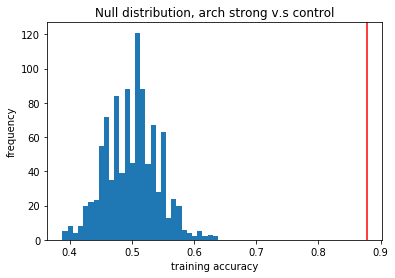

In [288]:
plt.hist(null_dist, bins=30)
plt.ylabel('frequency')
plt.xlabel('training accuracy')
plt.axvline(x=data_acc,color = 'red',label = 'data statistic')
plt.title('Null distribution, arch strong v.s control')
sum(null_dist>data_acc)/len(null_dist)

### Neural Network

In [310]:
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 2.0.0


In [323]:
random.seed(474747)
treatment_control = df[df['arm'].isin([treatment_label,control_label])]
X = np.array(treatment_control['post_q'].apply(cleanText))
y = treatment_control['arm']
X_clean = clean_tokenize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train_clean = clean_tokenize(X_train)
X_test_clean = clean_tokenize(X_test)

max_words = 50
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(X_train_clean) # only fit on train
x_train = tokenize.texts_to_matrix(X_train_clean, mode = 'tfidf')
x_test = tokenize.texts_to_matrix(X_test_clean, mode = 'tfidf')

# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 30
epochs = 5

model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 120 samples, validate on 30 samples
Epoch 1/5
120/120 [==============================] - 0s 2ms/step - loss: 0.7182 - accuracy: 0.5750 - val_loss: 0.6147 - val_accuracy: 0.6000
Epoch 2/5
120/120 [==============================] - 0s 311us/step - loss: 0.6216 - accuracy: 0.6500 - val_loss: 0.5562 - val_accuracy: 0.7667
Epoch 3/5
120/120 [==============================] - 0s 284us/step - loss: 0.4886 - accuracy: 0.7917 - val_loss: 0.5210 - val_accuracy: 0.7667
Epoch 4/5
120/120 [==============================] - 0s 192us/step - loss: 0.4147 - accuracy: 0.8333 - val_loss: 0.5023 - val_accuracy: 0.7667
Epoch 5/5
38/38 [==============================] - 0s 137us/step
Test score: 0.45322724078830917
Test accuracy: 0.8421052694320679


## Word Cloud

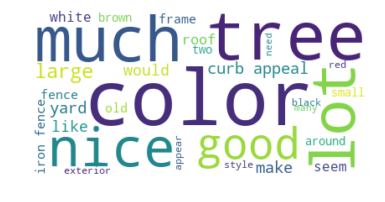

In [98]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

label = 'curb_appeal'

treatment_control = df[df['arm'].isin([label])]
X = np.array(treatment_control['post_q'].apply(cleanText))

def clean(X):
    sentences = []
    for res in X:
        tokens = gensim.utils.simple_preprocess(res)
        cleaned_tokens = ""
        for token in tokens:
            if token not in stop_words:
                cleaned_tokens+=token
                cleaned_tokens += " "
        sentences.append(cleaned_tokens)
    return sentences

X_clean = clean(X)

text = " ".join(text for text in X_clean)
stop_words_cloud = []
stop_words_cloud.append('house')
stop_words_cloud.append('window')
stop_words_cloud.append('home')
stop_words_cloud.append('also')
stop_words_cloud.append('look')
stop_words_cloud.append('front')
stop_words_cloud.append('brick')
stop_words_cloud.append('door')
wordcloud = WordCloud(stopwords = stop_words_cloud,background_color="white",max_words=30).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.show()
plt.savefig(label+'_wordcloud.png')